In [1]:
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Custom classes
from loader import StockPriceLoader
from preprocessor import Preprocessor
from training_engine import TrainingEngine
from reporting import Reporting

Using TensorFlow backend.


In [2]:
#ecb46fc18506ca6879fd4f7b9ce53f1b4261df9a3b778ad4

stock_history_reader = StockPriceLoader()
preprocessor = Preprocessor()
training_engine = TrainingEngine()
reporting = Reporting()

In [3]:
symbols = ['jpm']
look_back = 2
epochs = 2
no_of_features = 1

# fix random seed for reproducibility
np.random.seed(43)

               Open     High      Low    Close        Volume
Date                                                        
1998-01-02  22.9612  23.2635  22.7351  23.2635  4.293872e+06
1998-01-05  23.6482  23.8194  23.4622  23.7137  1.142683e+07
1998-01-06  23.2508  23.4622  22.5237  22.6569  1.705200e+07
1998-01-07  22.5639  22.8682  22.0481  22.7224  1.543968e+07
1998-01-08  22.6695  22.7499  21.9953  22.0481  1.384532e+07


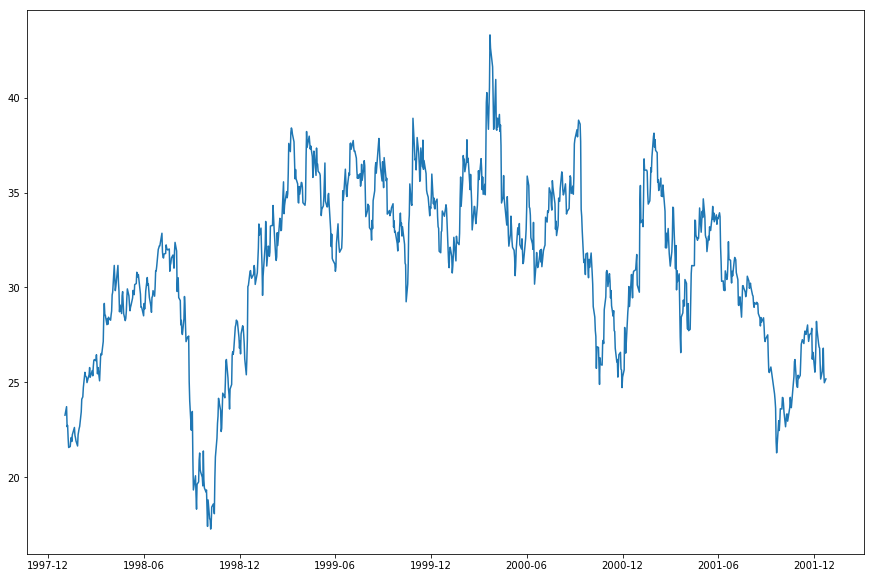

In [4]:
historical_data = stock_history_reader.load_single_stock('jpm')
historical_data = historical_data[:1000]

print historical_data.head()

close = historical_data["Close"]

plt.figure(figsize=(15, 10))
plt.plot(close)
plt.show()

In [5]:
dataset = close.values
dataset.astype('float32')

print "Before normalized"
print dataset[:3]

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = dataset.reshape(-1, 1)
dataset = scaler.fit_transform(dataset)

print "After reshaped and normalized"
print dataset[:3]

Before normalized
[ 23.2635  23.7137  22.6569]
After reshaped and normalized
[[ 0.23047218]
 [ 0.24775347]
 [ 0.20718736]]


In [6]:
# split into train and test sets
train, test = preprocessor.split_data(dataset)

print "Splitting data into {} training data and {} test data".format(len(train), len(test))

Splitting data into 670 training data and 330 test data


In [7]:
# convert to dataset matrix
print "Original Training Data"
print train[:4]
trainX, trainY = preprocessor.convert_dataset(train, look_back)
testX, testY = preprocessor.convert_dataset(test, look_back)
print "TrainX[0]"
print trainX[:1]
print "TrainY[0]"
print trainY[:1]
print "TrainX[1]"
print trainX[1:2]
print "TrainY[1]"
print trainY[1:2]

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], no_of_features))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], no_of_features))

print trainX.shape[0]

Original Training Data
[[ 0.23047218]
 [ 0.24775347]
 [ 0.20718736]
 [ 0.20970163]]
TrainX[0]
[[[ 0.23047218]
  [ 0.24775347]]]
TrainY[0]
[[ 0.20718736]]
TrainX[1]
[[[ 0.24775347]
  [ 0.20718736]]]
TrainY[1]
[[ 0.20970163]]
667


In [8]:
# create and fit the LSTM network
model = training_engine.create_model(trainX, trainY, epochs, no_of_features, look_back)

Epoch 1/2


7s - loss: 0.0804 - acc: 0.0015
Epoch 2/2


6s - loss: 0.0182 - acc: 0.0030


In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
inversedTrainPredict = scaler.inverse_transform(trainPredict.reshape(-1, 1))
inversedTrainY = scaler.inverse_transform(trainY.reshape(-1, 1))
inversedTestPredict = scaler.inverse_transform(testPredict.reshape(-1, 1))
inversedTestY = scaler.inverse_transform(testY.reshape(-1, 1))

print inversedTrainY[:5]
print inversedTrainPredict[:5]

[[ 22.6569]
 [ 22.7224]
 [ 22.0481]
 [ 21.5598]
 [ 21.6127]]
[[ 25.06432343]
 [ 24.98245049]
 [ 24.63783264]
 [ 24.51641273]
 [ 24.20728683]]


Train Score: 2.03 RMSE
Test Score: 1.45 RMSE


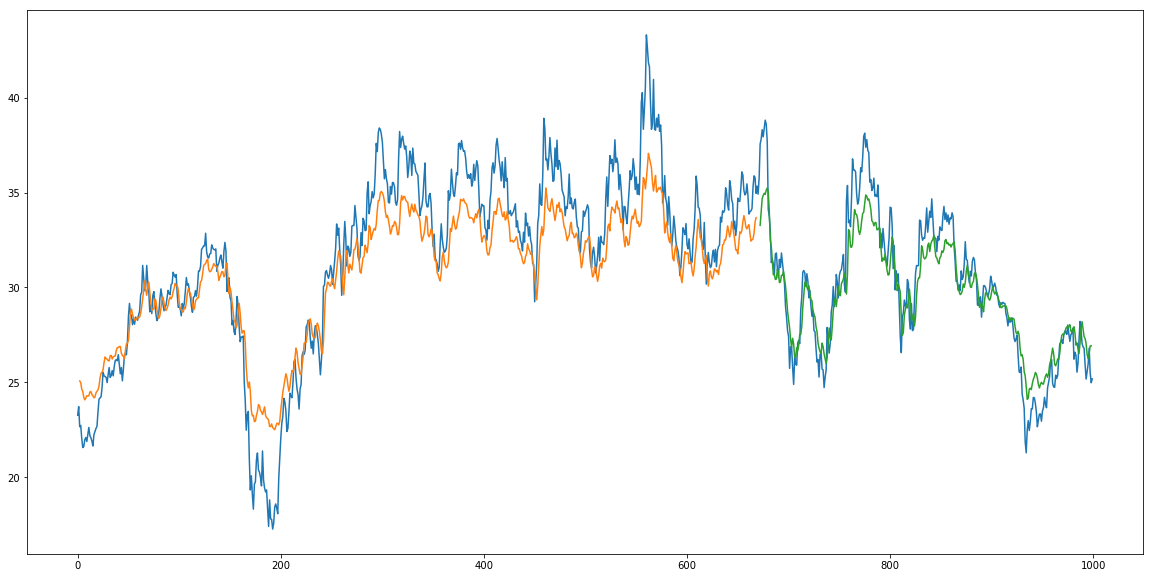

In [10]:
#reporting.print_results(close.values, inversedTrainPredict[:,0], inversedTrainY[:,0], inversedTestPredict[:,0], inversedTestY[:,0], look_back)

start=0
end=-1
reporting.print_results(close.values, inversedTrainPredict[:,0], inversedTrainY[:,0], inversedTestPredict[:,0], inversedTestY[:,0], \
                        look_back, start, end)